In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

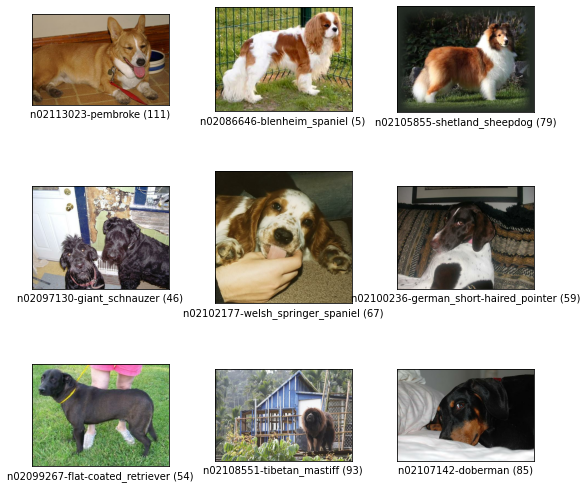

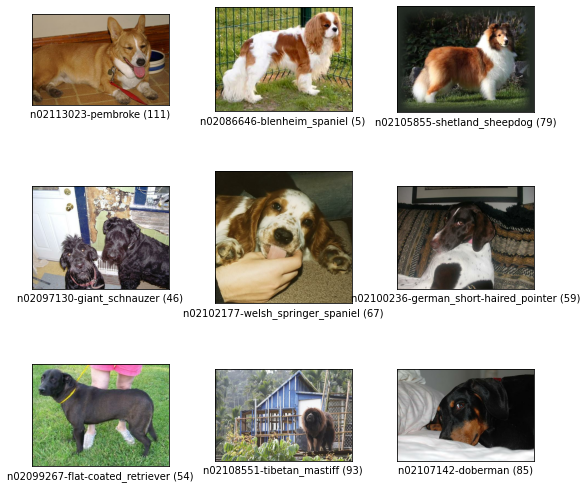

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

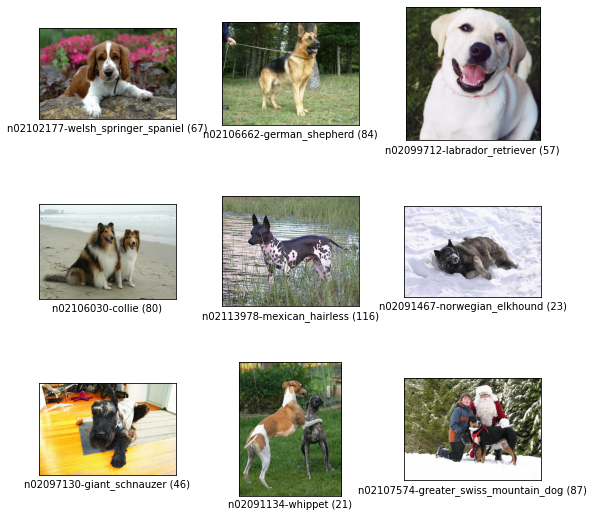

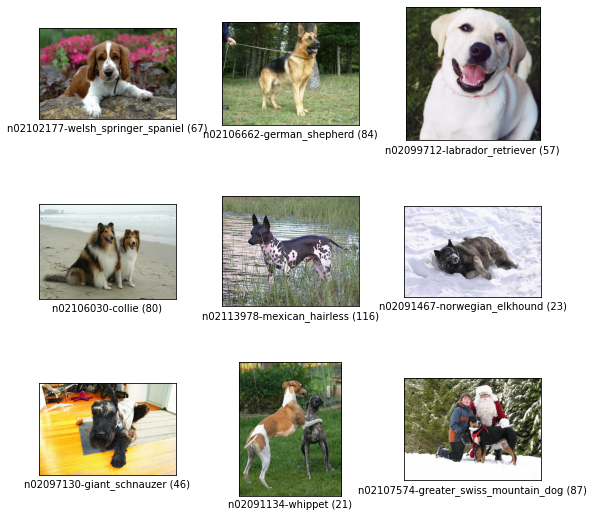

In [3]:
tfds.show_examples(ds_test, ds_info)

In [4]:
ds_info.features
# 'minmax' 바운딩박스, format: [ymin, xmin, ymax, xmax]

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image


In [7]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)
    
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=50,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

(16, 224, 224, 3)
(16,)
Epoch 1/50
750/750 [==============================] - 172s 216ms/step - loss: 2.2046 - accuracy: 0.4487 - val_loss: 3.0491 - val_accuracy: 0.2521
Epoch 2/50
750/750 [==============================] - 160s 214ms/step - loss: 0.7021 - accuracy: 0.8037 - val_loss: 1.0553 - val_accuracy: 0.6867
Epoch 3/50
750/750 [==============================] - 161s 214ms/step - loss: 0.2276 - accuracy: 0.9538 - val_loss: 1.1009 - val_accuracy: 0.6894
Epoch 4/50
750/750 [==============================] - 160s 213ms/step - loss: 0.0644 - accuracy: 0.9951 - val_loss: 0.9074 - val_accuracy: 0.7354
Epoch 5/50
750/750 [==============================] - 160s 214ms/step - loss: 0.0285 - accuracy: 0.9987 - val_loss: 0.9156 - val_accuracy: 0.7372
Epoch 6/50
750/750 [==============================] - 160s 214ms/step - loss: 0.0184 - accuracy: 0.9993 - val_loss: 0.9492 - val_accuracy: 0.7327
Epoch 7/50
750/750 [==============================] - 160s 214ms/step - loss: 0.0136 - accuracy: 0.9

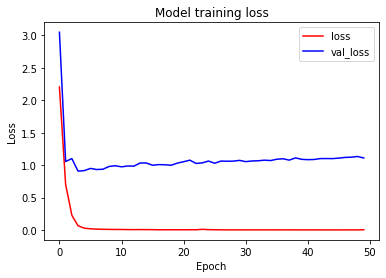

In [8]:
import matplotlib.pyplot as plt

plt.plot(history_cam_model.history['loss'], 'r')
plt.plot(history_cam_model.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

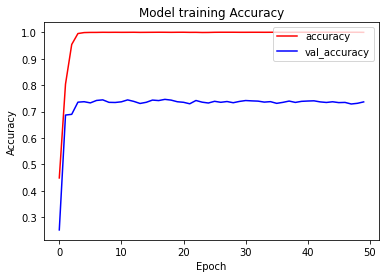

In [9]:
plt.plot(history_cam_model.history['accuracy'], 'r')
plt.plot(history_cam_model.history['val_accuracy'], 'b')
plt.title('Model training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')
plt.show()

In [10]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


67


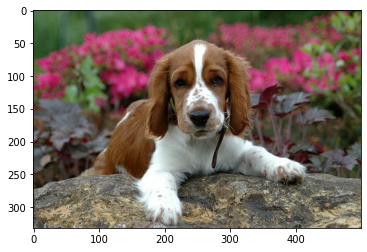

In [11]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [12]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

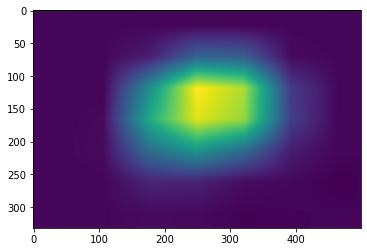

In [13]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

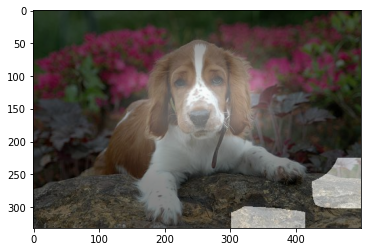

In [14]:
# CAM 이미지를 원본 이미지와 합친 이미지.
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM


In [15]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

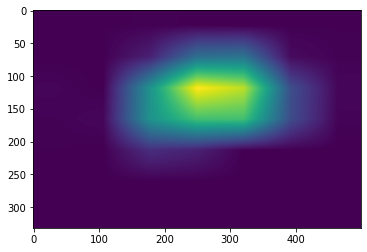

In [16]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image1)
plt.show()

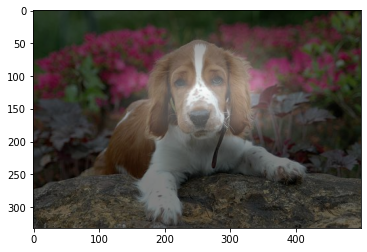

In [17]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image1*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

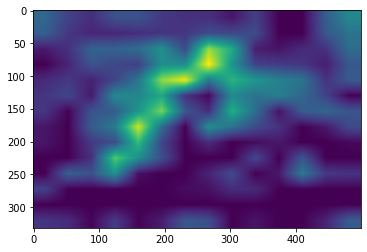

In [18]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)
plt.show()

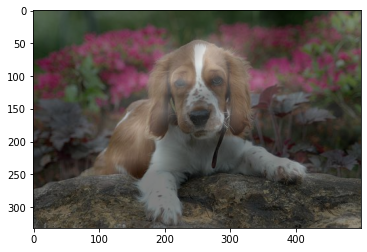

In [19]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image2*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

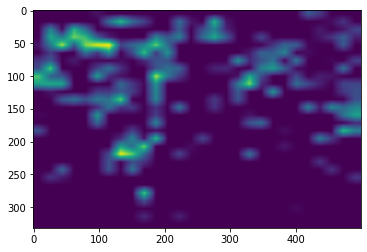

In [20]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

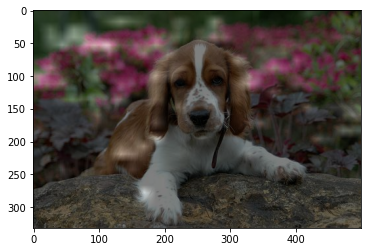

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 바운딩 박스 구하기

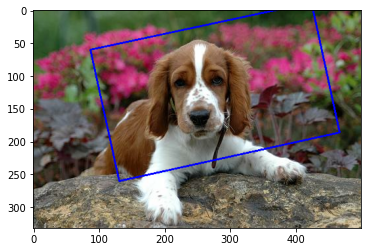

In [22]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

rect1 = get_bbox(grad_cam_image1)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect1], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

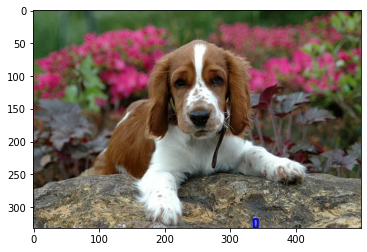

In [23]:
rect2 = get_bbox(grad_cam_image2)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect2], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

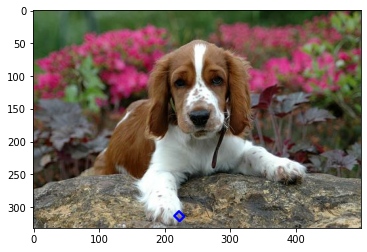

In [24]:
rect3 = get_bbox(grad_cam_image3)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect3], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

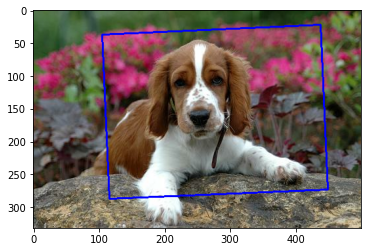

In [25]:
# CAM
rect = get_bbox(cam_image)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IoU 구하기

In [26]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox



In [27]:
# Grad-CAM IoU
pred_bbox = rect_to_minmax(rect1, item['image'])
print(get_iou(pred_bbox, item['objects']['bbox'][0]))
pred_bbox = rect_to_minmax(rect2, item['image'])
print(get_iou(pred_bbox, item['objects']['bbox'][0]))
pred_bbox = rect_to_minmax(rect3, item['image'])
print(get_iou(pred_bbox, item['objects']['bbox'][0]))

#CAM IoU
pred_bbox = rect_to_minmax(rect, item['image'])
print(get_iou(pred_bbox, item['objects']['bbox'][0]))

0.5412772956393782
0.0006234545308475793
0.002338391241212841
0.6605224593573364


## 회고

바운딩 박스는 딥하지않은 컨볼루션의 연산에서 가져온 grad_CAM 이미지에서 바운딩 박스가 잘 이루어졌다고 할 수 있다. 하지만 CAM 이미지가 더 IoU가 높았던 결과가 나왔다. 그러므로 Grad-CAM보다 CAM이미지가 더 바운딩 박스가 잘 생성되었다고 할 수 있을 것이다.